In [1]:
import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 596), started 0:14:44 ago. (Use '!kill 596' to kill it.)

## Data Processing and Train Test Split

In [2]:
df = pd.read_csv(r'D:\Github\Projects\Dota_Winrate_Analysis\Data\Export\200k matches export.csv')
df.drop(df.loc[df['game_mode'] != 22].index,inplace=True )
df['Radiant']='R'+df['player_1'].map(str)+','+'R'+df['player_2'].map(str)+','+'R'+df['player_3'].map(str)+','+'R'+df['player_4'].map(str)+','+'R'+df['player_5'].map(str)
df['Dire']='D'+df['player_6'].map(str)+','+'D'+df['player_7'].map(str)+','+'D'+df['player_8'].map(str)+','+'D'+df['player_9'].map(str)+','+'D'+df['player_10'].map(str)
Radiant = df['Radiant'].str.get_dummies(sep=',')
Dire = df['Dire'].str.get_dummies(sep=',')
dfmodel = Radiant.join(Dire)
dfmodel['Radiant Win'] = df['radiant_win'].astype(int)

In [15]:
df.radiant_win.mean()

0.523359307767574

In [3]:
Train, Test = train_test_split(dfmodel, test_size=0.2,random_state=1)
xTrain = Train.drop(labels = 'Radiant Win',axis=1)
xTest = Test.drop(labels = 'Radiant Win',axis=1)
yTrain = Train['Radiant Win']
yTest = Test['Radiant Win']
xTrain, yTrain, xTest, yTest

(        R1  R10  R100  R101  R102  R103  R104  R105  R106  R107  ...  D90  \
 55726    0    0     1     0     0     0     0     0     1     0  ...    0   
 50673    0    0     0     0     0     0     1     0     0     0  ...    0   
 97216    1    0     0     0     0     0     0     0     0     0  ...    0   
 52862    0    0     0     0     0     0     1     0     0     0  ...    0   
 109272   1    0     0     0     0     0     0     0     0     0  ...    0   
 ...     ..  ...   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...   
 29611    0    0     0     0     0     0     0     0     0     1  ...    0   
 100529   0    0     0     0     0     0     0     0     0     0  ...    0   
 68547    0    0     1     0     0     0     0     0     0     0  ...    0   
 7156     1    0     0     0     0     0     0     0     0     0  ...    0   
 106621   0    0     0     0     0     0     0     0     0     0  ...    0   
 
         D91  D92  D93  D94  D95  D96  D97  D98  D99  
 55726 

## Final Logistic Regression Model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, metrics

Logit = LogisticRegression(C=1e5,max_iter=1000).fit(xTrain,yTrain)
predictions = model_selection.cross_val_predict(Logit, xTest, yTest, cv=10)
prob_predictions = model_selection.cross_val_predict(Logit, xTest, yTest, cv=10,method='predict_proba')
print (metrics.accuracy_score(yTest, predictions))

0.5523399740657786


### Logistic Metrics

              precision    recall  f1-score   support

           0       0.53      0.44      0.48      7993
           1       0.57      0.65      0.61      8973

    accuracy                           0.55     16966
   macro avg       0.55      0.55      0.54     16966
weighted avg       0.55      0.55      0.55     16966

Confusion Matrix:


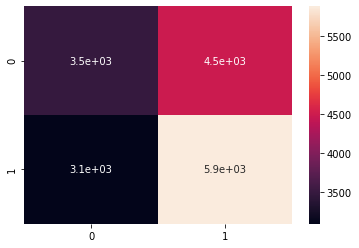

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
#TP,FP
#FN,TN
print (metrics.classification_report(yTest, predictions))
confusion = confusion_matrix(yTest, predictions)
print('Confusion Matrix:')
sn.heatmap(confusion, annot=True)

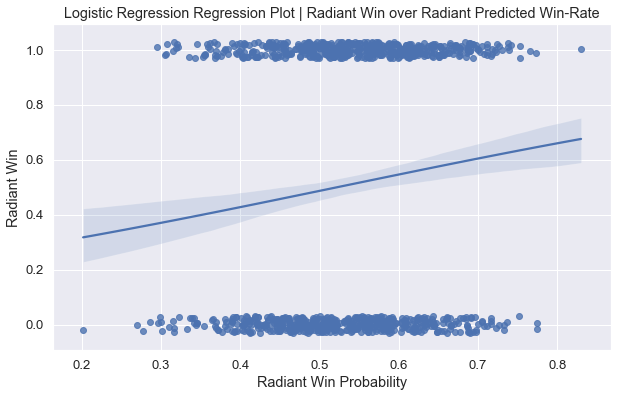

In [37]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt 
%matplotlib inline

predictdf = pd.DataFrame(data = prob_predictions, columns=['Dire Win Predict', 'Radiant Win Probability'])
Truedf = pd.DataFrame(data = yTest).reset_index(drop=True)
dfpredictgraph = pd.concat([Truedf, predictdf], axis=1)
dfpredictgraph_sample=dfpredictgraph.sample(1000)

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
ax = sns.regplot(x ="Radiant Win Probability", y = 'Radiant Win', data = dfpredictgraph_sample,
                 logistic=True, y_jitter=.03).set_title("Logistic Regression Regression Plot | Radiant Win over Radiant Predicted Win-Rate")

## Final Tensorflow Model

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime

log_dir = r"logs/fit/final/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +'/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 1000000)
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

### Model
model = tf.keras.Sequential()
#layer 1
model.add(layers.Dense(16, input_dim=(xTrain.shape[1]), activation='relu', kernel_constraint = tf.keras.constraints.unit_norm()))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(rate=0.7))
#layer 2
model.add(layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
#Output layer
model.add(layers.Dense(1, activation='sigmoid'))
###

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.fit(xTrain, yTrain, epochs=100, batch_size=100,validation_split=0.3,shuffle = True,verbose=1,  
          callbacks=[tensorboard_callback, es_callback])

scores, acc = model.evaluate(xTest, yTest)
print('Test score:', scores)
print('Test accuracy:', acc)

model.evaluate(xTest,  yTest, verbose=2)
ypredict = model.predict(xTest)
ypredict_binary = [1 if n >= 0.5 else 0 for n in ypredict]

Train on 47502 samples, validate on 20359 samples
Epoch 1/100
47502/47502 [==============================] - 2s 40us/sample - loss: 0.8623 - accuracy: 0.5095 - val_loss: 0.6975 - val_accuracy: 0.5229
Epoch 2/100
47502/47502 [==============================] - 1s 27us/sample - loss: 0.7175 - accuracy: 0.5149 - val_loss: 0.6920 - val_accuracy: 0.5253
Epoch 3/100
47502/47502 [==============================] - 1s 22us/sample - loss: 0.6980 - accuracy: 0.5137 - val_loss: 0.6914 - val_accuracy: 0.5241
Epoch 4/100
47502/47502 [==============================] - 1s 22us/sample - loss: 0.6932 - accuracy: 0.5225 - val_loss: 0.6911 - val_accuracy: 0.5244
Epoch 5/100
47502/47502 [==============================] - 1s 25us/sample - loss: 0.6921 - accuracy: 0.5230 - val_loss: 0.6908 - val_accuracy: 0.5256
Epoch 6/100
47502/47502 [==============================] - 1s 23us/sample - loss: 0.6914 - accuracy: 0.5256 - val_loss: 0.6904 - val_accuracy: 0.5285
Epoch 7/100
47502/47502 [=========================

### Tensorflow Metrics

Recall: 0.5416594190293964
Precision: 0.3895908920305267
Confusion Matrix:


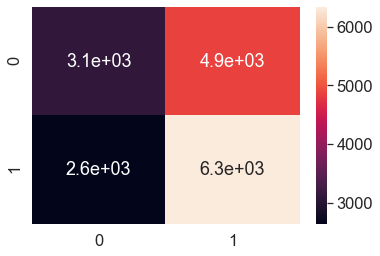

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
#TP,FP
#FN,TN
confusion = confusion_matrix(yTest, ypredict_binary)
TP = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TN = confusion[1,1]
Recall = (TP/(TP+FN)) #out of the positive classes, how many we predict correct
Precision = (TP/(TP+FP)) #Out of all the positive classes we have predicted correctly, how many are actually positive.
#Low Precision emerges when very few of your positive predictions are true.
print ('Recall: '+ str(Recall))
print ('Precision: ' + str(Precision))
print('Confusion Matrix:')
sn.heatmap(confusion, annot=True)

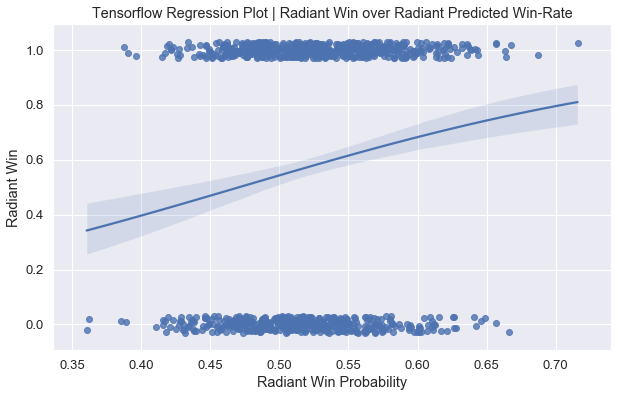

In [38]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt 
%matplotlib inline

predictdf = pd.DataFrame(data = ypredict, columns=['Radiant Win Probability'])
Truedf = pd.DataFrame(data = yTest).reset_index(drop=True)
dfpredictgraph = pd.concat([Truedf, predictdf], axis=1)
dfpredictgraph_sample=dfpredictgraph.sample(1000)


plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
ax = sns.regplot(x ="Radiant Win Probability", y = 'Radiant Win', data = dfpredictgraph_sample,
                 logistic=True, y_jitter=.03).set_title("Tensorflow Regression Plot | Radiant Win over Radiant Predicted Win-Rate")